<a href="https://colab.research.google.com/github/mohamedelziat50/Fruit-Recognition-MIU/blob/main/Fruit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Processing project for fruit recognition using the Fruits-360 dataset.

### Import The Necessary Libraries

In [190]:
import kagglehub
import os, sys
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Import The [Fruits-360 Dataset](https://www.kaggle.com/datasets/moltean/fruits) From Kaggle

In [191]:
# Load the dataset directly from kaggle (gives us the root path)
kaggle_dataset_path = kagglehub.dataset_download("moltean/fruits")

# Get the correct dataset path, by going inside the folders
dataset_path = os.path.join(kaggle_dataset_path, "fruits-360_100x100", "fruits-360")
print(f"Updated dataset path: {dataset_path}")

# Preview the contents of the path to double-check
print("\nFiles in the Dataset directory:", os.listdir(dataset_path))

Using Colab cache for faster access to the 'fruits' dataset.
Updated dataset path: /kaggle/input/fruits/fruits-360_100x100/fruits-360

Files in the Dataset directory: ['LICENSE', 'Training', 'README.md', 'Test']


### Store the Training & Testing paths independently

In [192]:
# Join the correct paths (checkout out the dataset's folder names on kaggle)
training_path = os.path.join(dataset_path, "Training")
testing_path = os.path.join(dataset_path, "Test")

# Display the Paths
print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}\n")

# Check if directories exist
print("Training directory exists:", os.path.exists(training_path))
print("Testing directory exists:", os.path.exists(testing_path))

Training Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Testing Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test

Training directory exists: True
Testing directory exists: True


### Load the training dataset
#### Create a `Fruit` class that will store the fruit's image & label (Training Data)

In [193]:
class Fruit:
  # Constructor With a 2 properties: image & label
  def __init__(self, image, label):
      self.image = image
      self.label = label

  # Getter for image
  @property
  def image(self):
      return self._image

  # Setter for image
  @image.setter
  def image(self, image):
      self._image = image

  # Getter for label
  @property
  def label(self):
      return self._label

  # Setter for label
  @label.setter
  def label(self, label):
      self._label = label

#### Main function that properly fetches the training data & returns a fruits list

In [194]:
def get_categories(fruit_categories):
    # Store in a list of Fruit Objects that have image & label
    fruits = []

    # Loop over each category
    for category in fruit_categories:
        category_path = os.path.join(training_path, category)

        # Get a list of images in that category
        category_images = os.listdir(category_path)

        # Loop over the images (ONE Image per category for now)
        for image in category_images[:1]:
            image_path = os.path.join(category_path, image)

            # Read the image using OpenCV & store inside the Fruit class
            fruit = Fruit(cv.imread(image_path), category)
            fruits.append(fruit)

    return sorted(fruits, key=lambda fruit: fruit.label)


#### Get the fruit categories & fruit list objects

In [195]:
# Get a list of all fruit categories (subdirectories) in the training path
fruit_categories = os.listdir(training_path)

# Display how many labels/categories we have
print("Number of Fruit Categories (Labels):", len(fruit_categories), end="\n\n")

# Get a list of all fruits as `Fruit` objects with image & label
fruits = get_categories(fruit_categories)

# Display how many fruit images we have
print("Number of Fruit Images (Training Data):", len(fruits))

Number of Fruit Categories (Labels): 228

Number of Fruit Images (Training Data): 228


#### Display a random portion of the fruits using Matplotlib
##### ⚠️ Only converts BGR (OpenCV's default) to RGB when displaying with Matplotlib

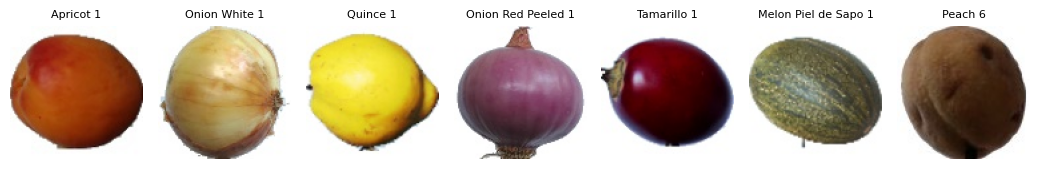

In [196]:
fruits_to_show = random.sample(fruits, 7)
rows, cols = 1, len(fruits_to_show)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, 2))

for ax, fruit in zip(axes, fruits_to_show):
    # Convert to RGB (Matplotlib) from BGR (OpenCV)
    rgb_image = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)

    # Show image
    ax.imshow(rgb_image)

    # Label on top
    ax.set_title(fruit.label, fontsize=8)

    # Remove ticks
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Preview the Color Histogram (BGR Color Space) for a sample fruit.


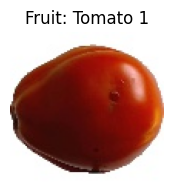

In [197]:
# We want the tomato image for now
fruit = None
for i, the_fruit in enumerate(fruits):
    if the_fruit.label == "Tomato 1":
        fruit = fruits[i]
        break

# Convert BGR image to RGB for Matplotlib
rgb_image = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(2, 2)) # Adjust the figure size (width, height in inches)
plt.imshow(rgb_image)
plt.title(f"Fruit: {fruit.label}")
plt.axis('off') # Hide axes for cleaner image display
plt.show()

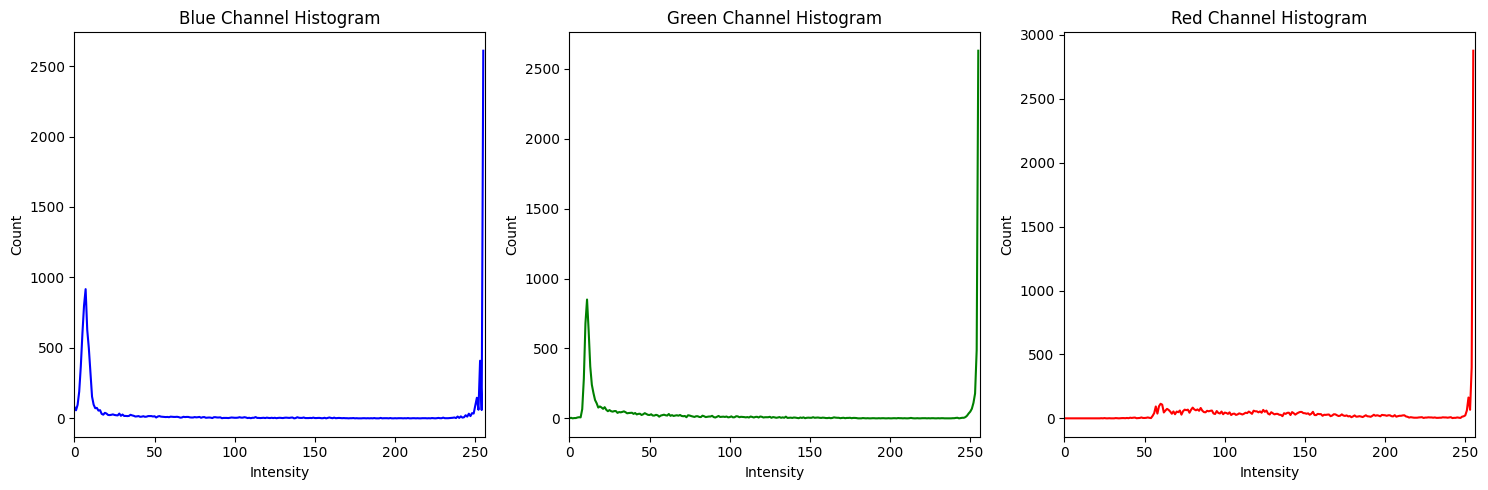

In [210]:
colors = ('b', 'g', 'r')
channel_names = ('Blue', 'Green', 'Red')

# Create figure for subplots
plt.figure(figsize=(15, 5))

# Iterate through channels and plot histograms using subplot indices
for i, (line_color, channel_name) in enumerate(zip(colors, channel_names)):
    plt.subplot(1, 3, i + 1)  # 1 row, 3 columns, current index
    histogram = cv.calcHist([fruit.image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=line_color)
    plt.xlim([0, 256])
    plt.title(channel_name + ' Channel Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Convert BGR To HSV Color Space
##### Hue: Base Color of the pixel (0 to 360 Degrees in theory, but 180 in OpenCV)
##### Saturation: Purity Of the color (lower saturation means its a shade of gray, high saturation means it a pure color, 0-100% - 0 to 255)
##### Value: Brightness of the color (Similar to grayscale: Between black & white, which side is it nearer to? 0 = black, 255 = white)

##### Conversion from RGB To HSV is crucial because the white background has near-zero saturation, while the colorful fruits have high saturation, making segmentation straightforward!

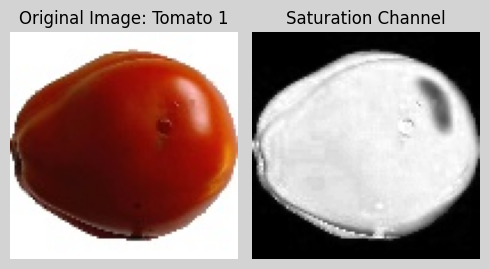


--- Saturation Channel Pixel Analysis ---
Minimum pixel value: 0
Maximum pixel value: 255

Sample saturation values:
  Pixel (43, 47): 240
  Pixel (65, 19): 230
  Pixel (49, 59): 249
  Pixel (14, 71): 225
  Pixel (96, 83): 0

White background pixels have low saturation (near 0)
Fruit region pixels have high saturation (near 255)
--- End Saturation Analysis ---


In [199]:
# Convert the BGR image to HSV
image_hsv = cv.cvtColor(fruit.image, cv.COLOR_BGR2HSV)
hue, saturation, value = cv.split(image_hsv) # Returns numpy arrays

# Display the original image
plt.figure(figsize=(5, 5), facecolor='lightgray')

# Original image (convert BGR to RGB for correct colors in matplotlib)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title(f"Original Image: {fruit.label}")
plt.axis('off')

# Saturation channel
plt.subplot(1, 2, 2)
plt.imshow(saturation, cmap='gray')
plt.title("Saturation Channel")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print information about the saturation channel to showcase its pixel values
print("\n--- Saturation Channel Pixel Analysis ---")
print(f"Minimum pixel value: {np.min(saturation)}")
print(f"Maximum pixel value: {np.max(saturation)}")

# Print sample pixel values from saturation channel
print("\nSample saturation values:")
for i in range(5):
    row, col = random.randint(0, 99), random.randint(0, 99)
    print(f"  Pixel ({row}, {col}): {saturation[row, col]}")

print("\nWhite background pixels have low saturation (near 0)")
print("Fruit region pixels have high saturation (near 255)")
print("--- End Saturation Analysis ---")

#### Display the HSV Histogram

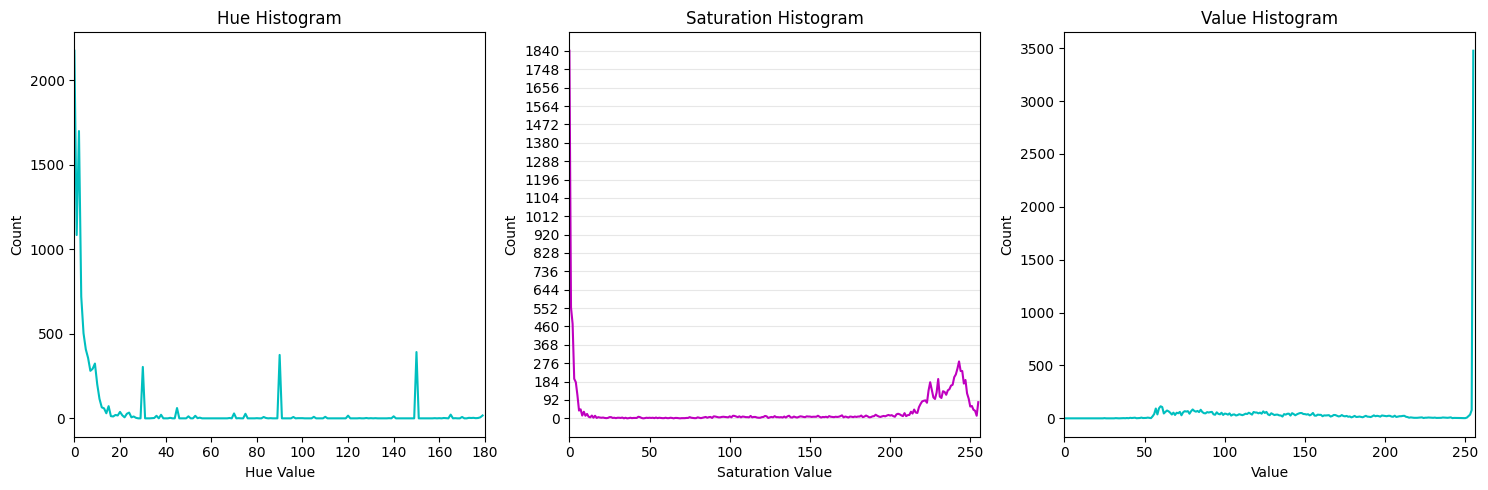


Notice (Saturation Histogram): Almost all intensities revolve around both ends (0 & 255), the others intensities have almost 0 count 


In [212]:
# Declare the histograms individually for a better view
hue_hist = cv.calcHist([hue], [0], None, [180], [0, 180]) # ([numpyarray], [channels(the index is 0 because we have one numpyarray)], [mask], [histogram_size], [range])
saturation_hist = cv.calcHist([saturation], [0], None, [256], [0, 256])
value_hist = cv.calcHist([value], [0], None, [256], [0, 256])

# Plot the histograms
plt.figure(figsize=(15, 5))

# Hue histogram
plt.subplot(1, 3, 1)  # 1 Row, 3 Columns, 1st Histogram
plt.title("Hue Histogram")
plt.plot(hue_hist, color='c')
plt.xlabel("Hue Value")
plt.ylabel("Count")
plt.xlim([0, 180])

# Saturation histogram
plt.subplot(1, 3, 2) # 1 Row, 3 Columns, 2nd Histogram
plt.title("Saturation Histogram")
plt.plot(saturation_hist, color='m')
plt.xlabel("Saturation Value")
plt.ylabel("Count")
plt.xlim([0, 256])

# Add detailed Y-axis ticks For Saturation Histogram
max_count = np.max(saturation_hist)
plt.yticks(np.arange(0, max_count + 1, max_count // 20))
plt.grid(axis='y', alpha=0.3)  # Add horizontal grid lines for better readability

# Value histogram
plt.subplot(1, 3, 3) # 1 Row, 3 Columns, 3rd Histogram
plt.title("Value Histogram")
plt.plot(value_hist, color='c')
plt.xlabel("Value")
plt.ylabel("Count")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

print("\nNotice (Saturation Histogram): Almost all intensities revolve around both ends (0 & 255), the others intensities have almost 0 count ")